In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

### Face Recognition using PCA & SVM (Eigenfaces)

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /home/kaveh/scikit_learn_data
Dataset shape: (400, 4096)
Number of subjects: 40
Images per subject: ~10


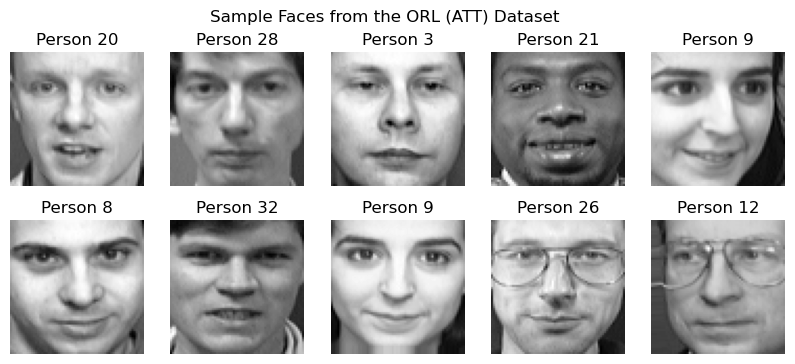

In [2]:

# Load the dataset
faces = fetch_olivetti_faces(shuffle=True, random_state=42)
X = faces.data  # flattened 64x64 images -> (4096,)
y = faces.target
n_samples, n_features = X.shape
n_classes = len(np.unique(y))

print(f"Dataset shape: {X.shape}")
print(f"Number of subjects: {n_classes}")
print(f"Images per subject: ~{n_samples // n_classes}")

# Display a few sample faces
fig, ax = plt.subplots(2, 5, figsize=(10, 4))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')
    axi.set_title(f"Person {y[i]}")
    axi.axis('off')
plt.suptitle("Sample Faces from the ORL (ATT) Dataset")
plt.show()

In [ ]:
# Split data into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y)


# Apply PCA to reduce data dimension (Eigenfaces)
#
# n_components=n_components: Number of principal components to keep
# If an integer (like 100): keeps exactly that many components.
# If None: keeps all components (no dimensionality reduction).
#
# whiten=True: Scales each principal component to have unit variance after projection.
# Helps algorithms like SVM perform better since the input features are standardized.
# However, it may amplify noise slightly if too many components are kept.
#
# random_state=42: Sets the seed for the random number generator.
# Ensures reproducibility of results by fixing the random seed.
# Note: PCA is deterministic, but the implementation here may use randomized SVD
# to speed up computations when the dataset is large or n_components is smaller than the number of features.
#
n_components = 100  # number of principal components
print(f"Extracting {n_components} eigenfaces from {X_train.shape[0]} training images...")
pca = PCA(n_components=n_components, whiten=True, random_state=42)
pca.fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"Training data array transformed from {X_train.shape} to {X_train_pca.shape}.")
print(f"Testing data array transformed from {X_test.shape} to {X_test_pca.shape}.")

Extracting 100 eigenfaces from 300 training images...
Training data array transformed from (300, 4096) to (300, 100).
Testing data array transformed from (100, 4096) to (100, 100).


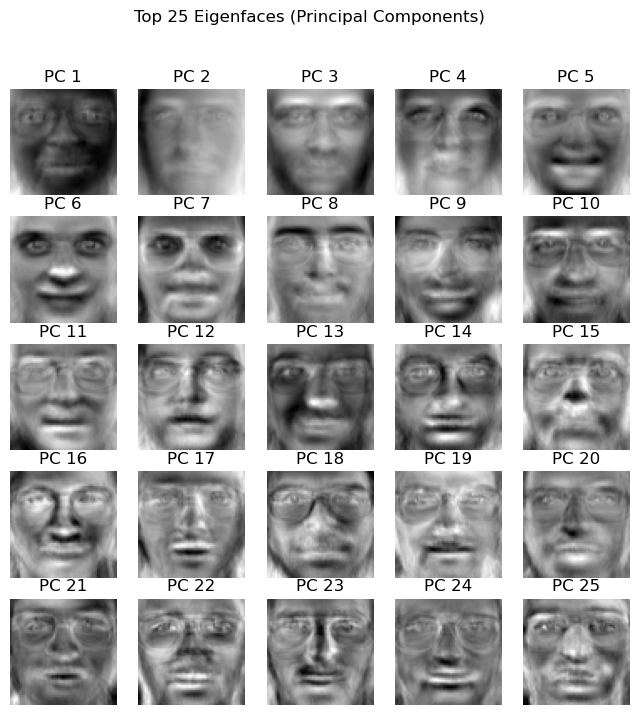

In [13]:
# Visualize some Eigenfaces
eigenfaces = pca.components_.reshape((n_components, 64, 64))

fig, ax = plt.subplots(5, 5, figsize=(8, 8))
for i, axi in enumerate(ax.flat):
    axi.imshow(eigenfaces[i], cmap='gray')
    axi.set_title(f"PC {i+1}")
    axi.axis('off')
plt.suptitle("Top 25 Eigenfaces (Principal Components)")
plt.show()

In [ ]:
# Train SVM classifier
#
# kernel='rbf': The Radial Basis Function (RBF) kernel (also known as Gaussian kernel) allows 
# the SVM to classify data that are not linearly separable by mapping inputs into a 
# higher-dimensional feature space.
#
# class_weight='balanced': Automatically adjusts class weights inversely proportional to class frequencies 
# to ensures that all classes contribute equally to the loss function 
# (useful when some subjects have fewer images or if data are imbalanced.)
#
# C=10: Regularization parameter that controls the trade-off between achieving a low training error.
# Large C (10-100): Less regularization => tries to classify all training points correctly => can overfit.
# Small C (0.1-1): More regularization => smoother boundary => may underfit.
#
# gamma=0.001: Kernel coefficient for RBF kernel that defines how far the influence of a single training example.
# Small gamma (0.001): The influence of each point is far-reaching => smoother, simpler decision boundary.
# Large gamma (0.1-1): Each point has a small area of influence => more complex, wiggly boundaries => may overfit.
#
print("Training SVM classifier on PCA-reduced data...")
clf = SVC(kernel='rbf', class_weight='balanced', C=10, gamma=0.001)
clf.fit(X_train_pca, y_train)


# Evaluate performance
y_pred = clf.predict(X_test_pca)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

Training SVM classifier on PCA-reduced data...

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         3
           2       1.00      0.67      0.80         3
           3       1.00      1.00      1.00         3
           4       0.67      1.00      0.80         2
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         2
          

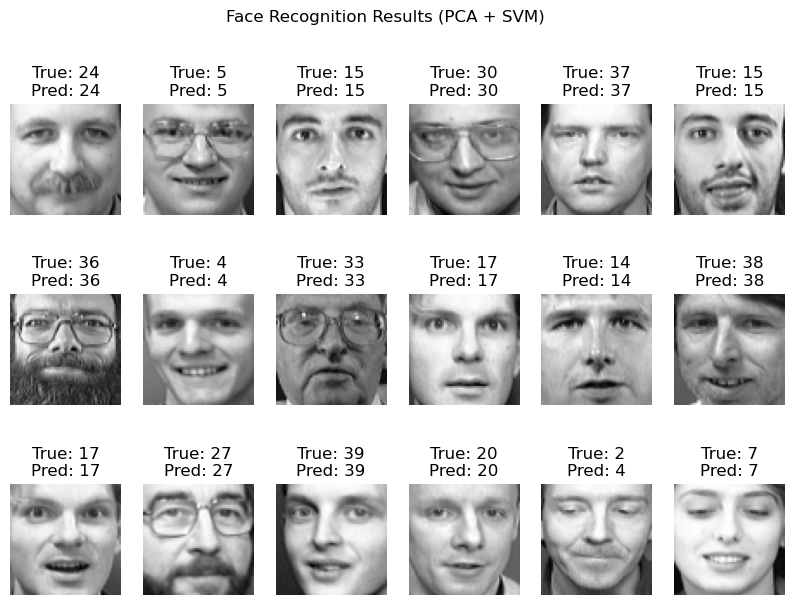

In [17]:

# Visualize some results
fig, ax = plt.subplots(3, 6, figsize=(10, 7))
for i, axi in enumerate(ax.flat):
    axi.imshow(X_test[i].reshape(64, 64), cmap='gray')
    axi.set_title(f"True: {y_test[i]}\nPred: {y_pred[i]}")
    axi.axis('off')
plt.suptitle("Face Recognition Results (PCA + SVM)")
plt.show()